<a href="https://colab.research.google.com/github/MartaAmoresCastillejo/LAB3/blob/main/LAB3PRAC1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ejercicio 1

Se quiere crear un modelo que permita saber si un atleta español va a tener medalla de oro, plata o bronce
en los juegos olímpicos de Tokio que se celebrarán en 2020.

In [1]:
import numpy as np 
import pandas as pd 
import sklearn as sk 
import matplotlib.pyplot as plt 
from matplotlib.cbook import boxplot_stats 
from math import sqrt 
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
import seaborn as sns
from prettytable import PrettyTable
import random
from sklearn.metrics import classification_report

Para realizar dicho ejercicio se utilizará una base de datos llamada 'olimpiadas' que recoge diferentes variables acerca de los jugadores que han participado en los Juegos Olímpicos.

In [2]:
data = pd.read_csv('olimpiadas.csv', encoding = 'latin_1')
data

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,Andrzej ya,M,29.0,179.0,89.0,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,NaN
271112,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",NaN
271113,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",NaN
271114,135571,Tomasz Ireneusz ya,M,30.0,185.0,96.0,Poland,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,NaN


¿Nuestra base de datos contiene valores nulos? 

In [3]:
data.isnull().values.any()

True

¿Cuántos valores nulos tenemos?

In [4]:
data.isnull().sum().sum()

363853

La siguiente función nos dice dónde se ubican nuestros valores nulos, es decir, en que columna los encontramos.

In [5]:
data.columns[data.isnull().any()]

Index(['Age', 'Height', 'Weight', 'Medal'], dtype='object')

Se ha decidido eliminar algunas de las variables que no hemos considerado 'relevantes' para nuestro estudio. Estas son:
*  **Team**, lo entendemos como el equipo en el que juega el jugador.Se ha observado que un jugador puede pertenecer a diferentes equipos, para ello, se ha decicido restringir de esta variable, por eliminar complejidades y recoger la variable NOC, que nos habla de la nacionalidad. 
*  **Year** y **season**, estas dos variables se recogen ambas juntas en la variable 'Games', para ello nos quedamos solo con la última. Nos interesa reducir dimensionalidad en estos casos para ayudar al algoritmo. 
*  **City**, esta variable nos indica dónde se jugaron los Juegos Olímpicos, pero gracias a la variable 'Games' ya podemos saber dónde fue, ya que lo único que habría que hacer es buscar dicha fecha y la época.
*   **ID**, esta variable nos indica un número que se le asigna a cada jugador, con el nombre nos bastaría. 

In [6]:
df = data.drop(['Team', 'Year', 'Season', 'City', 'ID'], axis=1)
df


,Name,Sex,Age,Height,Weight,NOC,Games,Sport,Event,Medal
0,A Dijiang,M,24.0,180.0,80.0,CHN,1992 Summer,Basketball,Basketball Men's Basketball,NaN
1,A Lamusi,M,23.0,170.0,60.0,CHN,2012 Summer,Judo,Judo Men's Extra-Lightweight,NaN
2,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,DEN,1920 Summer,Football,Football Men's Football,NaN
3,Edgar Lindenau Aabye,M,34.0,NaN,NaN,DEN,1900 Summer,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,Christine Jacoba Aaftink,F,21.0,185.0,82.0,NED,1988 Winter,Speed Skating,Speed Skating Women's 500 metres,NaN
...,...,...,...,...,...,...,...,...,...,...
271111,Andrzej ya,M,29.0,179.0,89.0,POL,1976 Winter,Luge,Luge Mixed (Men)'s Doubles,NaN
271112,Piotr ya,M,27.0,176.0,59.0,POL,2014 Winter,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",NaN
271113,Piotr ya,M,27.0,176.0,59.0,POL,2014 Winter,Ski Jumping,"Ski Jumping Men's Large Hill, Team",NaN
271114,Tomasz Ireneusz ya,M,30.0,185.0,96.0,POL,1998 Winter,Bobsleigh,Bobsleigh Men's Four,NaN


Ya se sabe las columnas que van a estar dentro de este ejercicio. Estas son:

*  **Name**: el nombre del jugador/a que ha participado en los Juegos Olímpicos.
*  **Sex**: el género del jugador/a.
*  **Age**: la edad del jugador/a.
*  **Height**: la altura del jugador/a.
*  **Weight**: el peso del jugador/a.
*  **NOC**: entendemos dicha variable como la nacionalidad del jugador/a.
*  **Games**: el año y la época en la que se han jugado los juegos.
*  **Sport**: el deporte realizado por el jugador/a.
*  **Event**: al igual que la variable anterior, pero más concreto. 
*  **Medal**: la medalla conseguida por el jugador/a, en este caso la **variable objetivo**. 


Ahora vamos a reemplazar los valores nulos.

Para empezar sabemos que la columna 'Medal' se encuentran valores nulos. Se entiende que el valor nulo es lo mismo que no tener medalla, para ello se va a reemplazr dichos valores por 'No', haciendo referencia a que el jugador no ha obtenido medalla. 

In [7]:
df['Medal']=df['Medal'].fillna("No")
df

,Name,Sex,Age,Height,Weight,NOC,Games,Sport,Event,Medal
0,A Dijiang,M,24.0,180.0,80.0,CHN,1992 Summer,Basketball,Basketball Men's Basketball,No
1,A Lamusi,M,23.0,170.0,60.0,CHN,2012 Summer,Judo,Judo Men's Extra-Lightweight,No
2,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,DEN,1920 Summer,Football,Football Men's Football,No
3,Edgar Lindenau Aabye,M,34.0,NaN,NaN,DEN,1900 Summer,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,Christine Jacoba Aaftink,F,21.0,185.0,82.0,NED,1988 Winter,Speed Skating,Speed Skating Women's 500 metres,No
...,...,...,...,...,...,...,...,...,...,...
271111,Andrzej ya,M,29.0,179.0,89.0,POL,1976 Winter,Luge,Luge Mixed (Men)'s Doubles,No
271112,Piotr ya,M,27.0,176.0,59.0,POL,2014 Winter,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",No
271113,Piotr ya,M,27.0,176.0,59.0,POL,2014 Winter,Ski Jumping,"Ski Jumping Men's Large Hill, Team",No
271114,Tomasz Ireneusz ya,M,30.0,185.0,96.0,POL,1998 Winter,Bobsleigh,Bobsleigh Men's Four,No


Para las otras columnas que tienen valores nulos, estas son 'Age', 'Height' y 'Weight', vamos a realizar la media de sus respectivas columnas y reemplazar los valore nulos por sus medias. Ya que si reemplazamos por un valor 0 estaríamos perdiendo mucha información y nos parece lo más adecuado realizar su media. 

In [8]:
df['Age']= df['Age'].fillna(df['Age'].mean())
df['Weight']= df['Weight'].fillna(df['Weight'].mean())
df['Height']= df['Height'].fillna(df['Height'].mean())

Verificamos que no nos quedan más valores nulos.

In [9]:
df.isnull().values.any()

False

Para entender mejor nuestros datos podemos observar la distribución de las columnas numéricas que tenemos en nuestro Dataset. 

Para ello vamos a realizar un diagrama de cajas. 

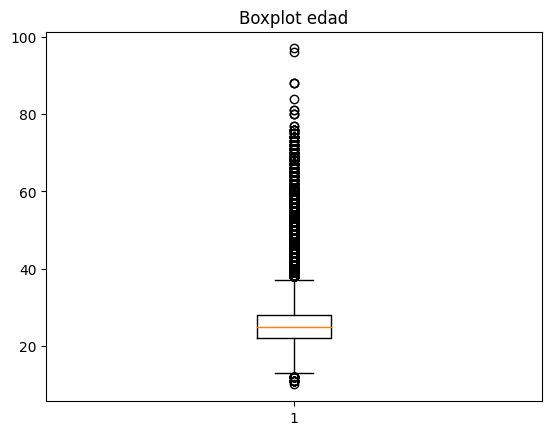

In [10]:
boxplot_age = df['Age']
plt.boxplot(boxplot_age)
plt.title('Boxplot edad')
plt.show()

In [11]:
min = df['Age'].min()
max = df['Age'].max()
print(min,max)

10.0 97.0


Con el diagrama de cajas y observando los valores máximos y mínimos hay algo que nos sorprende. 

Primero la edad mínima que sea de 10 años, se ha buscado información y el Comité de Juegos Olímpicos no manifiesta que exista una edad mínima para poder jugar a los juegos. Si biene es verdad, expone que hay diferentes juegos que **sí** que tienen límite de edad. Se ha decidido no realizar ningún cambio hacia estos valores.
Lo mismo pasa con la edad máximo, de hecho, exponen que **no** existe una edad máxima para jugar.

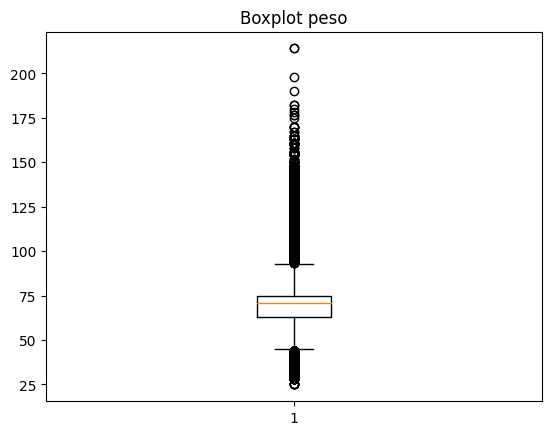

In [12]:
boxplot_weight = df['Weight']
plt.boxplot(boxplot_weight)
plt.title('Boxplot peso')
plt.show()

In [13]:
min = df['Weight'].min()
max = df['Weight'].max()
print(min,max)

25.0 214.0


En los Juegos existen diferentes deportes y que cada uno de ellos se necesita un peso diferente, o es mejor, llegar a un peso concreto. Por esto no se va a realizar ningún cambio.

Si bien es verdad nos sorprende el peso mínimo, pero viendo la edad mínima no vamos a realizar nada. 

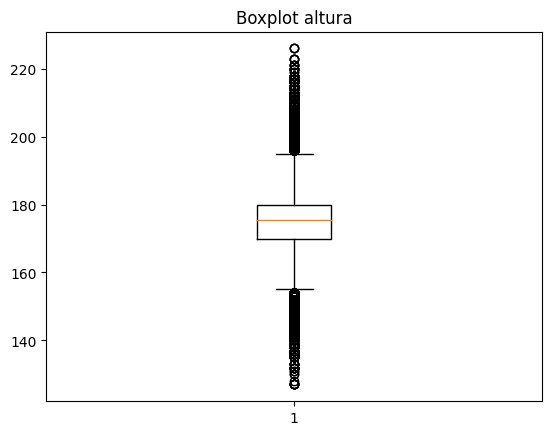

In [14]:
boxplot_Height = df['Height']
plt.boxplot(boxplot_Height)
plt.title('Boxplot altura')
plt.show()

In [15]:
min = df['Height'].min()
max = df['Height'].max()
print(min,max)

127.0 226.0


Por lo mismo que pasa con la variable 'Weight' no se va a realizar ningún cambio. En el caso de esta variable que nos explica la altura no nos soprenden estos valores.


Para el primer ejercicio debemos de separar nuestro Dataset en datos de entrenamiento y en datos de test. Se realiza esta partición ya que, para ejercicios posteriores se utilizará el algoritmo de **KNN**, y este es un algoritmo de **aprendizaje supervisado** para clasificar. Es importante separar el dataset, para que el algoritmo sea capaz de clasificar unos individuos que **no** haya visto nunca. 

In [16]:
col = ['Medal']
colum = list(set(df.columns) - set(col))
PruebaX = df[colum]
PruebaY= df[['Medal']]

# Dividir el conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(PruebaX, PruebaY, test_size=0.2, random_state=42)

Para el segundo ejercicio se pide la implementación de dos métricas principales. La primera métrica corresponde al número de individuos que vamos a utilizar para clasificar el nuevo individuo. 
Para esta primera métrica se han decicido utilizar estos valores : 3,5 y 7 individuos.
Para la segunda métrica se pide que midamos la cercanía del nuevo individuo con el resto, con esto vamos a utilizar las distancias que ya se han estudiado: Euclídea, Manhattan y Minkowski. Donde la distancia euclídea es la distancia “ordinaria” entre dos puntos de un espacio euclídeo. La Manhattan la suma de las diferencias absolutas de sus coordenadas. La Minkowski es una medida de distancia en un espacio n-dimensional, generalizando la distancia Euclidiana y la distancia Manhattan.

Todas ellas son utilizadas para valores continuos, por eso se ha pensado que se le va asignar un valor numérico a diferentes valores de las columnas de nuestro Dataset. Es decir, si en la columna 'Sport' existe Football se le puede asignar un valor 1, y al Basketball un valor de 19. Para ello se va a utilizar la función *LabelEncoder*.
Se ha decidido también realizar esta transformación porque el algoritmo de KNN (el que se va a utilizar) necesita valores numéricos.



In [17]:
le = LabelEncoder()
for col in PruebaX.columns: #Cambiar los strings del dataframe de x
    if PruebaX[col].dtype == 'object':
        PruebaX[col] = le.fit_transform(PruebaX[col])
for col in PruebaY.columns: #Cambiar los strings del dataframe de y
    if PruebaY[col].dtype == 'object':
        PruebaY[col] = le.fit_transform(PruebaY[col])


X_train, X_test, y_train, y_test = train_test_split(PruebaX, PruebaY, test_size=0.2, random_state=42)

# Definir las métricas
k_values = [3, 5, 7]
distance_metrics = ['euclidean', 'manhattan', 'minkowski']

# Para crear la tabla de salida
table = PrettyTable()
table.field_names = ["k", "metric", "accuracy", "error_medio"]

# Evaluamos el modelo para k y la distancia
for k in k_values:
    for metric in distance_metrics:
        # Función fit entrena el modelo
        model = KNeighborsClassifier(n_neighbors=k, metric=metric)
        model.fit(X_train, y_train)
        
        # Predecimos con el set de prueba
        y_pred = model.predict(X_test)
        
        # Calculamos la precisión
        accuracy = accuracy_score(y_test, y_pred)

        # Calculamos el error medio (RMSE) 
        mse = mean_squared_error(y_test, y_pred)
        rmse = sqrt(mse)        
        
        # Agregar la configuración y la precisión del modelo a la tabla
        table.add_row([k, metric, accuracy, rmse])

print(table)

<ipython-input-17-42e25b5a1253>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PruebaX[col] = le.fit_transform(PruebaX[col])
<ipython-input-17-42e25b5a1253>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PruebaX[col] = le.fit_transform(PruebaX[col])
<ipython-input-17-42e25b5a1253>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

+---+-----------+--------------------+--------------------+
| k |   metric  |      accuracy      |    error_medio     |
+---+-----------+--------------------+--------------------+
| 3 | euclidean | 0.8069673945116553 | 0.6975619346695399 |
| 3 | manhattan | 0.8092173207435822 | 0.6979583893390393 |
| 3 | minkowski | 0.8069673945116553 | 0.6975619346695399 |
| 5 | euclidean | 0.8325280318678077 | 0.6100340049246068 |
| 5 | manhattan | 0.8339849513130717 | 0.6083538634164065 |
| 5 | minkowski | 0.8325280318678077 | 0.6100340049246068 |
| 7 | euclidean | 0.8444969017409265 | 0.5758363386716655 |
| 7 | manhattan | 0.8443862496311596 | 0.5766684262954771 |
| 7 | minkowski | 0.8444969017409265 | 0.5758363386716655 |
+---+-----------+--------------------+--------------------+


De la tabla podemos explicar que:
No nos importa utilizar la distancia euclidea y la de minkowski ya que para cada k, indiferentemente de cuál sea, siempre obtenemos los mimos valores.

 ¿Por qué puede ser? la distancia euclídea es un caso particular de la distancia de Minkowski. Conocemos que ambas distancias miden la distancia entre dos puntos en un espacio de n-dimensiones. La euclídea mide la distancia directa entre dos puntos y la minkowski lo hace ajustando el grado de importancia que se le da a cada dimensión en función de un parámetro p. Cuando a 'p' se le asigna un valor lo que hace la distancia de Minkowski es reducir dicho valor a la distancia euclídea. Lo que hace que ambos valores sean iguales.

Otra cosa que vemos en la tabla es que, a medida que el número de individuos crece, la precisión también crece y el valor del error baja. (Vamoa a realizar otra prueba para comprobar esto).

In [18]:
# Definir las métricas
k_values = [5, 7, 11]
distance_metrics = ['euclidean', 'manhattan', 'minkowski']

# Para crear la tabla de salida
table = PrettyTable()
table.field_names = ["k", "metric", "accuracy", "error_medio"]

# Evaluamos el modelo para k y la distancia
for k in k_values:
    for metric in distance_metrics:
        # Función fit entrena el modelo
        model = KNeighborsClassifier(n_neighbors=k, metric=metric)
        model.fit(X_train, y_train)
        
        # Predecimos con el set de prueba
        y_pred = model.predict(X_test)
        
        # Calculamos la precisión
        accuracy = accuracy_score(y_test, y_pred)

        # Calculamos el error medio (RMSE) 
        mse = mean_squared_error(y_test, y_pred)
        rmse = sqrt(mse)        
        
        # Agregar la configuración y la precisión del modelo a la tabla
        table.add_row([k, metric, accuracy, rmse])

print(table)

/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

+----+-----------+--------------------+--------------------+
| k  |   metric  |      accuracy      |    error_medio     |
+----+-----------+--------------------+--------------------+
| 5  | euclidean | 0.8325280318678077 | 0.6100340049246068 |
| 5  | manhattan | 0.8339849513130717 | 0.6083538634164065 |
| 5  | minkowski | 0.8325280318678077 | 0.6100340049246068 |
| 7  | euclidean | 0.8444969017409265 | 0.5758363386716655 |
| 7  | manhattan | 0.8443862496311596 | 0.5766684262954771 |
| 7  | minkowski | 0.8444969017409265 | 0.5758363386716655 |
| 11 | euclidean | 0.8508225140159339 | 0.5540963098293823 |
| 11 | manhattan | 0.8514311006196518 | 0.5538133315978703 |
| 11 | minkowski | 0.8508225140159339 | 0.5540963098293823 |
+----+-----------+--------------------+--------------------+


Estábamos en lo cierto, a medida que aumentamos el valor de k, los valores son mejores. Esto se debe a que al aumentar el número de vecinos, el algoritmo considera una mayor cantidad de información de los datos cercanos al punto que queremos clasificar. Al tener en cuenta más vecinos, también se reduce el error que pueda haber cometido o, los outliers.

Tras aplicar dicho algoritmo se ha pensado que, dependiendo del número que se le atribuya a una variable, esta va a coger más peso que otra. Es decir, si yo le atribuyo al fútbol femenino un 1 y al fútbol masculino un 9, tienen pesos diferentes, cuando en realidad no debería de ser así. Existen variables que tienen relación entre ellas y asignandoles un número estamos asignándoles un peso muy diferente. 

Para ello podemos realizar el ejercicio con otra forma de transformar los datos. Con one-hot encoding, sabemos que este atribuye valores binarios a las variables. También conocemos que existe una distancia que trabaja con valores categóricos, la distancia de **Hamming**. 

Antes de realizar el algoritmo de KNN, debemos de categorizar los valores continuos, así aplicamos sencillez al entrenamiento. 

In [19]:
datos = df.copy()

In [20]:
corte1 = min
corte2 = max
datos['Weight_cat'] = "Delgado"
datos.loc[(datos['Weight'] > corte1) & (datos['Weight'] <= corte2), 'Weight_cat'] = "En forma"
datos.loc[datos['Weight'] > corte2, 'Weight_cat'] = "Grande"

In [21]:
corte1 = min
corte2 = max
datos['Height_cat'] = "Bajo"
datos.loc[(datos['Height'] > corte1) & (datos['Height'] <= corte2), 'Height_cat'] = "Medio"
datos.loc[datos['Height'] > corte2, 'Height_cat'] = "Alto"

In [22]:
corte1 = min
corte2 = max
datos['Age_cat'] = "Baja"
datos.loc[(datos['Age'] > corte1) & (datos['Age'] <= corte2), 'Age_cat'] = "Media"
datos.loc[datos['Age'] > corte2, 'Age_cat'] = "Alta"

In [23]:
datos = datos.drop(['Age', 'Height', 'Weight'], axis=1)
datos

,Name,Sex,NOC,Games,Sport,Event,Medal,Weight_cat,Height_cat,Age_cat
0,A Dijiang,M,CHN,1992 Summer,Basketball,Basketball Men's Basketball,No,Delgado,Medio,Baja
1,A Lamusi,M,CHN,2012 Summer,Judo,Judo Men's Extra-Lightweight,No,Delgado,Medio,Baja
2,Gunnar Nielsen Aaby,M,DEN,1920 Summer,Football,Football Men's Football,No,Delgado,Medio,Baja
3,Edgar Lindenau Aabye,M,DEN,1900 Summer,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Delgado,Medio,Baja
4,Christine Jacoba Aaftink,F,NED,1988 Winter,Speed Skating,Speed Skating Women's 500 metres,No,Delgado,Medio,Baja
...,...,...,...,...,...,...,...,...,...,...
271111,Andrzej ya,M,POL,1976 Winter,Luge,Luge Mixed (Men)'s Doubles,No,Delgado,Medio,Baja
271112,Piotr ya,M,POL,2014 Winter,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",No,Delgado,Medio,Baja
271113,Piotr ya,M,POL,2014 Winter,Ski Jumping,"Ski Jumping Men's Large Hill, Team",No,Delgado,Medio,Baja
271114,Tomasz Ireneusz ya,M,POL,1998 Winter,Bobsleigh,Bobsleigh Men's Four,No,Delgado,Medio,Baja


Ya se ha pasado los valores continuos a categóricos. Como antes se ha comentado, se ha realizado para utilizar el *One Hot Encoding* en el algoritmo de KNN. 

Este código se ha realizado pero el algoritmo tarda en ejecutarse, eso puede ser, por la cantidad de datos que tenemos. 
Nota: es muy parecido al código anterior ya que lo único que varia, es la transformación de los datos.

Se ha pensado que se podría hacer una partición para ver que tal se comporta, pero hemos decidido no realizarlo, independientemente de que puedan trabajar mejor con *One Hot Encoding*. Ya que lo que quiero saber es que tal se comporta nuestro algoritmo ante **todos** los datos que tenemos. Se ha hablado del problema que teníamos con el *LaberEncoder* y se tiene en cuenta a la hora de ver los errores. 

En el tercer apartado pide que se esocoga la mejor configuración para el algoritmo. Implemetando una tabla para ver como evoluciona las configuraciones. Ya hemos visto gracias a la tabla como evoluciona el entrenamiento. 
Ahora lo que queremos ver es cómo se comporta nuestra mejor configuración. Vamos a coger la de k = 11 con la distancia **euclídea**. Recordemos: no nos importa utilizar la distancia euclídea o la Minkowski ya que obtenemos lo mismos números. Podemos comprobar esto con la matriz de confusión. 

/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

([<matplotlib.axis.XTick at 0x7f374dfaa700>,
 [Text(0, 0, '0'),
  Text(5, 0, '5'),
  Text(10, 0, '10'),
  Text(15, 0, '15'),
  Text(20, 0, '20')])

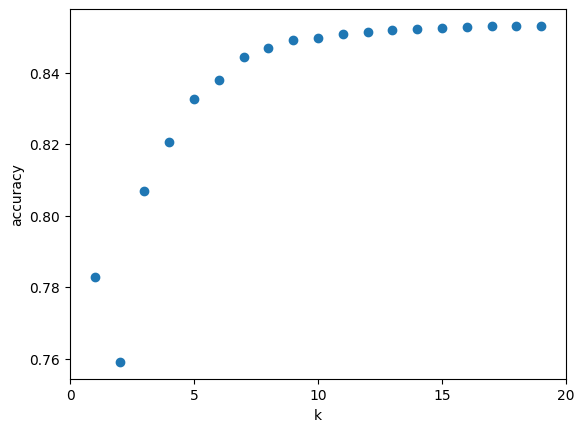

In [24]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

Observamos que para diferentes valores de k, la precisión va subiendo, como ya habíamos pensado.

In [25]:
model = KNeighborsClassifier(n_neighbors=11, metric="euclidean")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[[   27    47  2605    13]
 [   15   164  2443    17]
 [   77   244 45929    40]
 [   23    58  2507    15]]


In [26]:
model = KNeighborsClassifier(n_neighbors=11, metric="minkowski")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[[   27    47  2605    13]
 [   15   164  2443    17]
 [   77   244 45929    40]
 [   23    58  2507    15]]


Obtenemos una matriz de confusión que muestra el rendimiento del modelo de clasificación K-Vecinos más Cercanos en los datos de prueba. 

Las filas en la matriz de confusión representan las clases verdaderas, es decir, los valores reales de la variable objetivo. Las columnas, por otro lado, representan las clases predichas por el modelo. Como en nuestro caso tenemos 4 clases a clasificar: Oro, Plata, Bronce y No medalla, nos sale una matriz 4x4. Como se ha realizado con la función *Label Encoder* se le ha asignado un valor aleatorio a los valores de clasificación. Debemos de saber a cuál se refiere cada uno para poder interpretar bien la matriz.

Los valores son:
*  Oro: 1
*  Plata: 3
*  Bronce: 0
*  No medalla: 2

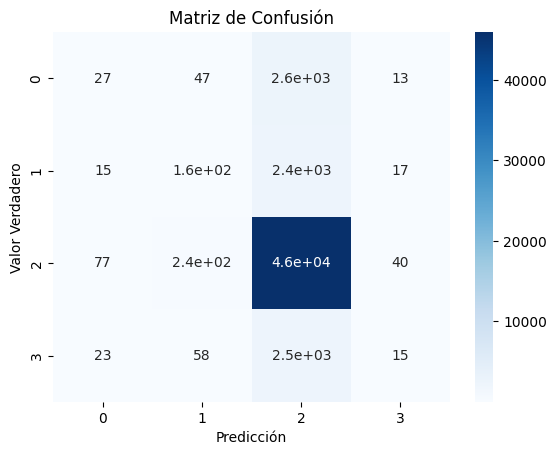

In [27]:
cm = confusion_matrix(y_test, y_pred)

# Crear mapa de calor de la matriz de confusión
sns.heatmap(cm, annot=True, cmap='Blues')

# Agregar etiquetas
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

Conociendo los valores ya podemos sacar conclusiones. Sabemos que el valor que mejor predice es aquellos jugadores que **no** tienen medalla,  esto puede ser ya que es el valor que más predomina en nuestro Dataframe, es decir, hay muchos más valores. Seguido por la medalla de oro que es la segunda que mejor predice. Si bien es verdad, no nos parece que prediga de la mejor manera que habíamos esperado. También vemos que ha clasificado muchas veces que los jugadores no tenían medalla y si que tenían, esto pasa por lo que hemos dicho anteriormente, hay muchos valores de esta variable. 

La segunda configuración que nos parece la mejor, es la de k = 7 y, para variar de distancia, la distancia de Minkowski. 



Para realizar un gráfico, al tener muchas características se hace imposible gráficar todas a la vez. Se he pensado que se puede realizar la gráfica de dos de las variables. 

Por ejemplo, vamos a realizar la gráfica en función del peso y la altura (que pueden tener una relación entre ellas). Los diferentes colores de la gráfica corresponden a los tipos de medalla que puede tener un jugador/a. 

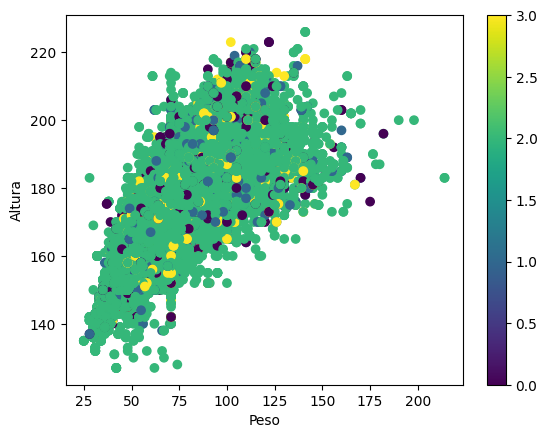

In [28]:
for col in PruebaX.columns:
    if PruebaX[col].dtype == 'object':
        PruebaX[col] = le.fit_transform(PruebaX[col])
        
# Cambiar los strings del dataframe de y
for col in PruebaY.columns:
    if PruebaY[col].dtype == 'object':
        PruebaY[col] = le.fit_transform(PruebaY[col])

# Crear el gráfico de dispersión
plt.scatter(PruebaX['Weight'], PruebaX['Height'], c=PruebaY['Medal'], cmap='viridis')
plt.xlabel('Peso')
plt.ylabel('Altura')
plt.colorbar()
plt.show()

Aquí podemos ver que el valor que más predomina es el 2, que son aquellas que no consiguen medalla. No observamos muy bien la diferncia de valores al clasificar.
Se ha realizado para otros atributos y tampoco se encuentran patrones al tener un volumen muy elevado de datos. 

Podemos pensar que si realizamos una simplificación de la base de datos, cogiendo 500 filas que no se repitan. 

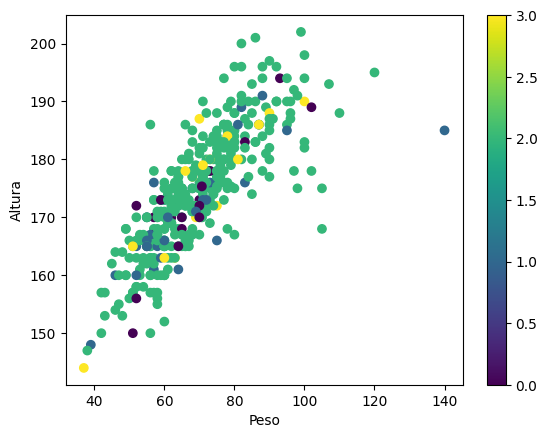

In [29]:
PruebX = PruebaX.sample(n=500, replace=False)
PruebY = PruebaY.sample(n=500, replace=False)
for col in PruebaX.columns:
    if PruebX[col].dtype == 'object':
        PruebX[col] = le.fit_transform(PruebX[col])
        
# Cambiar los strings del dataframe de y
for col in PruebY.columns:
    if PruebY[col].dtype == 'object':
        PruebY[col] = le.fit_transform(PruebY[col])

# Crear el gráfico de dispersión
plt.scatter(PruebX['Weight'], PruebX['Height'], c=PruebY['Medal'], cmap='viridis')
plt.xlabel('Peso')
plt.ylabel('Altura')
plt.colorbar()
plt.show()

Realmente tampoco conseguimos ver ningún patron válido. O no somos capaces de encontrarlo. 

Para clasificar para saber que medalla es más probable que gane Carolina Marín y Bruno Hortelano hay que conocer primero sus características. Realizamos una búsqueda. 

Hay diferentes cosas a tener en cuenta: Carolina Marín no se encuentra en el set de datos, entonces no se le atribuye ningún número. Lo que se ha pensado es añadir a Carolina Marín en el set de datos. Pero ojo, debemos de añadirla al set de datos de prueba, donde no se encuentra la columna objetivo, que es la medalla. 



In [30]:
col = ['Medal']
colum = list(set(df.columns) - set(col))
PruebaX = df[colum]
PruebaY= df[['Medal']]

# Dividir el conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(PruebaX, PruebaY, test_size=0.2, random_state=42)

In [31]:
nueva_fila = pd.DataFrame({'Name': "Carolina Marín", 'Age': 29, 'Height': 172, 'Weight': 65, 'Sport': "Badminton", 'NOC': "ESP", 'Event': "Badminton Women's Singles", 'Games':"2016 Summer", 'Sex':"F"}, index=[271116])
PruebaX = PruebaX.append(nueva_fila, ignore_index=True)

<ipython-input-31-c4353d7579bb>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  PruebaX = PruebaX.append(nueva_fila, ignore_index=True)


Se ha añadido la fila con las características de Carolina Marín al set de datos, para que la función *Label Encoder* le atribuya un número. A la hora de entrenar el modelo vamos a quitar dicha columna así vemos que tal se comporta con datos que nunca a visto, y a la función predict, se le va a pasar la fila que hemos añadido para que prediga la medalla.

In [32]:
le = LabelEncoder()

for col in PruebaX.columns:
    if PruebaX[col].dtype == 'object':
        PruebaX[col] = le.fit_transform(PruebaX[col])

for col in PruebaY.columns:
    if PruebaY[col].dtype == 'object':
        PruebaY[col] = le.fit_transform(PruebaY[col])

x = PruebaX.iloc[:-1]

predecir = PruebaX.tail(1)


X_train, X_test, y_train, y_test = train_test_split(x, PruebaY, test_size=0.3, random_state=42)

model = KNeighborsClassifier(n_neighbors=11, metric="euclidean")
model.fit(x, PruebaY)

y_pred = model.predict(predecir)
print(y_pred)

<ipython-input-32-e7d1f1d268aa>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PruebaY[col] = le.fit_transform(PruebaY[col])
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[2]


Se ha predicho que Carolina Marín no va a obtener medalla.

In [33]:
col = ['Medal']
colum = list(set(df.columns) - set(col))
PruebaX = df[colum]
PruebaY= df[['Medal']]

# Dividir el conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(PruebaX, PruebaY, test_size=0.2, random_state=42)

In [34]:
nueva_fila = pd.DataFrame({'Name': "Bruno Hortelano", 'Age': 31, 'Height': 181, 'Weight': 72, 'Sport': "Athletics", 'NOC': "AUS", 'Event': "Athletics Men's 200 metres", 'Games':"2016 Summer", 'Sex':"M"}, index=[271116])
PruebaX = PruebaX.append(nueva_fila, ignore_index=True)

<ipython-input-34-e99408520a95>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  PruebaX = PruebaX.append(nueva_fila, ignore_index=True)


In [35]:
le = LabelEncoder()

for col in PruebaX.columns:
    if PruebaX[col].dtype == 'object':
        PruebaX[col] = le.fit_transform(PruebaX[col])

for col in PruebaY.columns:
    if PruebaY[col].dtype == 'object':
        PruebaY[col] = le.fit_transform(PruebaY[col])

x = PruebaX.iloc[:-1]

predecir = PruebaX.tail(1)


X_train, X_test, y_train, y_test = train_test_split(x, PruebaY, test_size=0.3, random_state=42)

model = KNeighborsClassifier(n_neighbors=11, metric="euclidean")
model.fit(x, PruebaY)

y_pred = model.predict(predecir)
print(y_pred)

<ipython-input-35-e7d1f1d268aa>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PruebaY[col] = le.fit_transform(PruebaY[col])
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[2]


Nuestro algoritmo ha predicho que Bruno Hortelano no va a tener medalla.


En ambos casos se ha decidido predecir, los juegos de verano de 2016. Se ha buscado información y sabemos que estos juegos fueron en Rio de Janeiro, y Carolina Marín sí que consiguió medalla en esos juegos, ganó la medalla de oro. Sin embargo, Bruno Hortelano no consiguió medalla en esos juegos. 

Para predecir que medalla van a obtener la selección femenina de Baloncesto hay que reducir el dataset. Ya que variables como el nombre, el peso o la edad, no vamos a poder ponerlas. Así que utilizaremos columnas como: Sport, Sex, Games, Event y NOC. Por otra parte debemos de eliminar las columnas que tengan los valores que vamos a predecir, ya que en el entrenamiento de muestra **no** pueden ver los valores que vamos a predecir. 

In [36]:
col = ['Medal']
colum = list(set(df.columns) - set(col))
PruebaX = df[colum]
PruebaY= df[['Medal']]

# Dividir el conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(PruebaX, PruebaY, test_size=0.2, random_state=42)


In [37]:
data =  df[(df['Event'] != "Basketball Women's Basketball") | (df['NOC'] != 'ESP') | (df['Games'] != "2016 summer")] 


PruebaX=data[['Games','NOC', 'Event', 'Sex', 'Sport']]
PruebaY= data[['Medal']]

new_row_X = {'Games': "2016 summer", 'NOC': "ESP", 'Event': "Basketball Women's Basketball"}
PruebaX = PruebaX.append(new_row_X, ignore_index=True)

le = LabelEncoder()

for col in PruebaX.columns:
    if PruebaX[col].dtype == 'object':
        PruebaX[col] = le.fit_transform(PruebaX[col])

for col in PruebaY.columns:
    if PruebaY[col].dtype == 'object':
        PruebaY[col] = le.fit_transform(PruebaY[col])

PruebaX_except_last = PruebaX.iloc[:-1]
ultima_fila = PruebaX.tail(1)


X_train, X_test, y_train, y_test = train_test_split(PruebaX_except_last, PruebaY, test_size=0.3, random_state=42)

model = KNeighborsClassifier(n_neighbors=11, metric="euclidean")
model.fit(PruebaX_except_last, PruebaY)

y_pred = model.predict(ultima_fila)
print(y_pred)

<ipython-input-37-e4e37bb4b268>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  PruebaX = PruebaX.append(new_row_X, ignore_index=True)
<ipython-input-37-e4e37bb4b268>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PruebaY[col] = le.fit_transform(PruebaY[col])
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[2]


La Selección Femenina de Baloncesto no va a conseguir medalla.

Como conclusiones: 